### Import Modules

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

### 1) Reading the image

we use `open cv` to read the image:

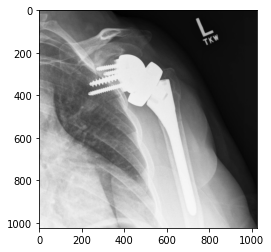

In [47]:
img = cv2.imread('shoulder.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

### 2) Fourier transform

We use the functions implemented in HW4-Q3 to apply the fourier transform:

In [48]:
def fourier(img):
    '''
    Performs the fourier transform on the image.
    :param img: the image to be transformed
    :return: the transformed image
    '''
    fourier_image = np.fft.fft2(img)
    # shift the image to the center
    return np.fft.fftshift(fourier_image) 

def plot_fourier(f_img):
    '''
    Plots the fourier transform of the image.
    :param img: fourier of the image to be transformed
    '''
    # get the magnitude of the image
    magnitude = np.abs(f_img)
    # log scaled magnitude
    log_magnitude = np.log(magnitude + 1)
    # get the phase of the image
    phase = np.angle(f_img)
    # plot
    fig, ax = plt.subplots(1, 4, figsize = (15, 4))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].imshow(magnitude, cmap='gray')
    ax[1].set_title('Magnitude')
    ax[2].imshow(log_magnitude, cmap='gray')
    ax[2].set_title('Log scaled magnitude')
    ax[3].imshow(phase, cmap='gray')
    ax[3].set_title('Phase')
    plt.show()

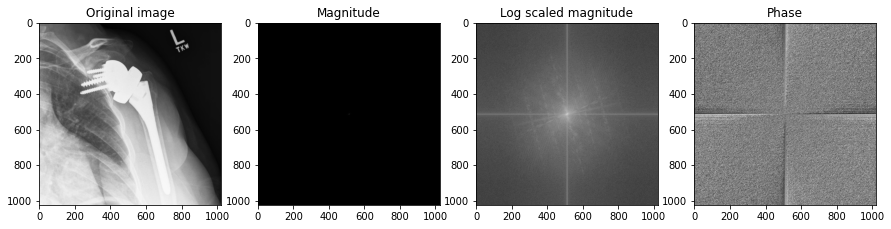

(1024, 1024)

In [49]:
f_image = fourier(img)
plot_fourier(f_image)
f_image.dtype
f_image.shape

### 3) Frequency filters

Now we want to implement 3 frequency filters:
1. Ideal low pass filter
2. Gaussian low pass filter
3. Butterworth low pass filter

The distance function is as follows:

$D(u, v) = \sqrt{(u - P/2)^2 + (v - Q/2)^2}$

In [50]:
def distance(u, v, shape):
    '''
    :param u: vertical position of the point
    :param v: horizintal position of the point
    :param h: height of the image
    :param w: width of the image
    :return the distance between the point and center of the image
    '''
    return math.sqrt((u - shape[0]//2)**2 + (v - shape[1]//2)**2)

def ideal_lpf(shape, thresh):
    '''
    :param h: height of the image
    :param w: width of the image
    :param thresh: the threshold distance
    :return an ideal low pass filter
    '''
    mask = np.zeros(shape, dtype=np.float32)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask[i, j] = 1 if distance(i, j, shape) <= thresh else 0
    return mask

def butterworth_lpf(shape, thresh, n):
    '''
    :param h: height of the image
    :param w: width of the image
    :param thresh: the threshold distance
    :param n: parameter n in formula [1 / (1 + [D(u,v) / thresh] ^ 2n)]
    :return a butterworth low pass filter
    '''
    mask = np.zeros(shape, dtype=np.float32)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask[i, j] = 1 / (1 + (distance(i, j, shape) / thresh) ** (2*n))
    return mask


def gaussian_lpf(shape, thresh):
    '''
    :param h: height of the image
    :param w: width of the image
    :param thresh: the threshold distance
    :return a butterworth low pass filter
    '''
    mask = np.zeros(shape, dtype=np.float32)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask[i, j] = math.exp(-(distance(i, j, shape)**2) / (2 * (thresh ** 2)))
    return mask

#### 4) Performing high pass filters

In this section, we'll use highpass filters with radius 30 and 100 to see their effect:

In [51]:
ones = np.ones(img.shape)

# radius 30
bw_30 = ones - butterworth_lpf(img.shape, 30, n = 2)
ideal_30 = ones - ideal_lpf(img.shape, 30)
gaus_30 = ones - gaussian_lpf(img.shape, 30)

#radius 100
bw_100 = ones - butterworth_lpf(img.shape, 100, n = 2)
ideal_100 = ones - ideal_lpf(img.shape, 100)
gaus_100 = ones - gaussian_lpf(img.shape, 100)


Now we can perform the filters:

In [52]:
# log_scaled_image = np.log(np.abs(f_image) + 1)

bw_30_result = bw_30 * f_image
ideal_30_result = ideal_30 * f_image
gaus_30_result = gaus_30 * f_image

bw_100_result = bw_100 * f_image
ideal_100_result = ideal_100 * f_image
gaus_100_result = gaus_100 * f_image

Now we can plot the resulting frequency domain:

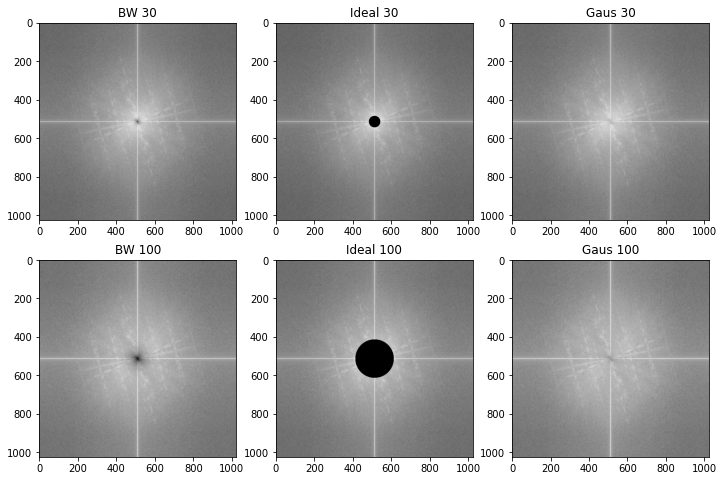

In [53]:
def log_abs(img):
    '''
    :param img: the image to be transformed
    :return the log scaled magnitude of the image
    '''
    magnitude = np.abs(img)
    log_magnitude = np.log(magnitude + 1)
    return log_magnitude

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

ax[0, 0].imshow(log_abs(bw_30_result), cmap='gray')
ax[0, 0].set_title('BW 30')

ax[0, 1].imshow(log_abs(ideal_30_result), cmap='gray')
ax[0, 1].set_title('Ideal 30')

ax[0, 2].imshow(log_abs(gaus_30_result), cmap='gray')
ax[0, 2].set_title('Gaus 30')

ax[1, 0].imshow(log_abs(bw_100_result), cmap='gray')
ax[1, 0].set_title('BW 100')

ax[1, 1].imshow(log_abs(ideal_100_result), cmap='gray')
ax[1, 1].set_title('Ideal 100')

ax[1, 2].imshow(log_abs(gaus_100_result), cmap='gray')
ax[1, 2].set_title('Gaus 100')

plt.show()

Now we can find iverse fourier transforms to get the images. We use the `inverse_fourier` function from HW4-Q3:

In [54]:
def inverse_fourier(f_image):
    '''
    Performs the inverse fourier transform on the image.
    :param f_image: the fourier transform of the image
    :return: the transformed image
    '''
    # shift the image to the center
    shifted_image = np.fft.ifftshift(f_image)
    # inverse fourier transform
    return np.fft.ifft2(shifted_image)

In [58]:
bw_30_new_image = np.abs(inverse_fourier(bw_30_result))
ideal_30_new_image = np.abs(inverse_fourier(ideal_30_result))
gaus_30_new_image = np.abs(inverse_fourier(gaus_30_result))

bw_100_new_image = np.abs(inverse_fourier(bw_100_result))
ideal_100_new_image = np.abs(inverse_fourier(ideal_100_result))
gaus_100_new_image = np.abs(inverse_fourier(gaus_100_result))

Now we can plot the images:

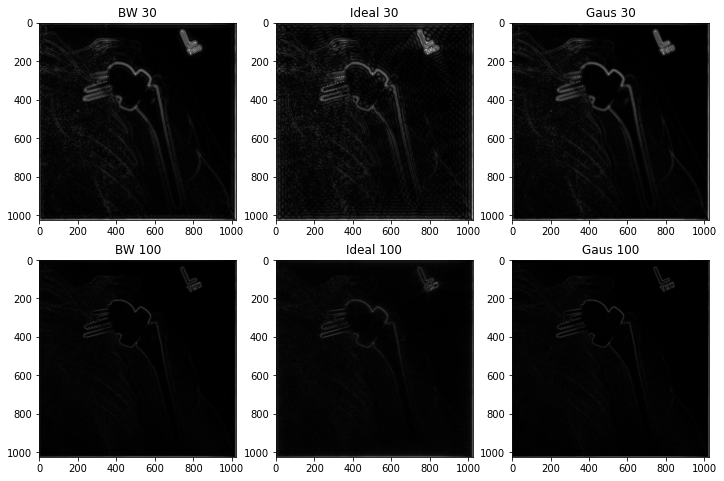

In [59]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8))

ax[0, 0].imshow(bw_30_new_image, cmap='gray')
ax[0, 0].set_title('BW 30')

ax[0, 1].imshow(ideal_30_new_image, cmap='gray')
ax[0, 1].set_title('Ideal 30')

ax[0, 2].imshow(gaus_30_new_image, cmap='gray')
ax[0, 2].set_title('Gaus 30')

ax[1, 0].imshow(bw_100_new_image, cmap='gray')
ax[1, 0].set_title('BW 100')

ax[1, 1].imshow(ideal_100_new_image, cmap='gray')
ax[1, 1].set_title('Ideal 100')

ax[1, 2].imshow(gaus_100_new_image, cmap='gray')
ax[1, 2].set_title('Gaus 100')

plt.show()